In [20]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions

In [26]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size: int, action_size: int, hidden_size: int = 1024):
        super(PolicyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, state: torch.Tensor):
        return self.model.forward(state)

In [27]:
class PolicyGradient:
    def __init__(self, env: gym.Env, num_episodes: int = 1000, gamma: float = 0.99, step_size: float = 0.001) -> None:
        self.env: gym.Env = env
        self.num_episodes: int = num_episodes
        self.gamma: float = gamma

        self.policy: PolicyNetwork = PolicyNetwork(self.env.observation_space.shape[0], self.env.action_space.n)
        self.optimizer: torch.optim.Optimizer = optim.Adam(self.policy.parameters(), lr=step_size)

    def train(self) -> tuple[list]:
        scores = []
        losses = []
        for episode in range(self.num_episodes):
            state, _ = self.env.reset()
            done = False

            transitions = []
            while not done:
                action_probabilities = self.policy.forward(torch.from_numpy(state))
                action = distributions.Categorical(action_probabilities).sample()
                _, reward, terminated, truncated, _ = self.env.step(action.numpy())
                transitions.append((state, action, reward))
                done = terminated or truncated

            returns = []
            total = 0
            for _, _, reward in reversed(transitions):
                returns.append(reward + self.gamma * total)
                total += reward
            returns.reverse()

            state_batch = torch.Tensor(np.array([s for s, _, _ in transitions]))
            action_batch = torch.LongTensor(np.array([a for _, a, _ in transitions]))
            return_batch = torch.FloatTensor(returns)
            return_batch /= return_batch.max()

            prediction_batch = self.policy.forward(state_batch)
            probability_batch = prediction_batch.gather(dim=1, index=action_batch.view(-1, 1)).squeeze()

            loss = -torch.sum(torch.log(probability_batch) * return_batch)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            scores.append(len(transitions))
            losses.append(loss.item())

        return scores, losses

In [28]:
env = gym.make("CartPole-v1")
agent = PolicyGradient(env)
info = agent.train()

Text(0, 0.5, 'Lifespan (# steps)/Losses')

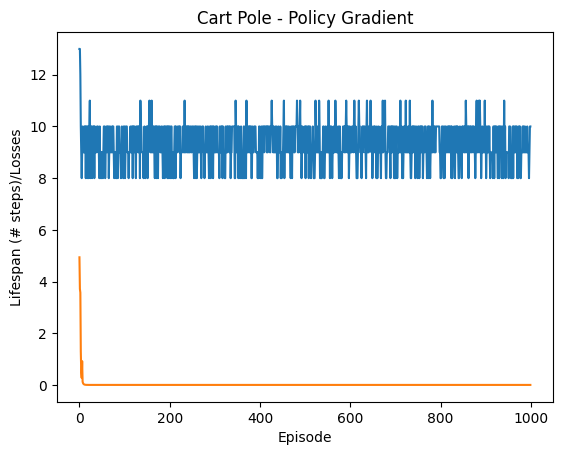

In [29]:
scores, losses = info
plt.plot(range(len(scores)), scores)
plt.plot(range(len(losses)), losses)
plt.title("Cart Pole - Policy Gradient")
plt.xlabel("Episode")
plt.ylabel("Lifespan (# steps)/Losses")